In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData
import theano
theano.config.gcc.cxxflags = "-fbracket-depth=16000" # default is 256
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

In [2]:
pc_mas_yr_per_km_s = (1 * u.km/u.s).to(u.pc*u.mas/u.yr, u.dimensionless_angles()).value
km_s_per_pc_mas_yr = 1 / pc_mas_yr_per_km_s

In [3]:
g = GaiaData('/Users/apricewhelan/data/GaiaDR2/rv-good-plx.fits')

In [4]:
the_og = g[g.source_id == 1490845584382687232]
v0 = the_og.get_skycoord().velocity.d_xyz.value.T[0]
sigma_0 = 0.6  # km/s
v0

array([-6.93189151, 24.30123728, -9.50923957])

In [5]:
(100*u.Myr * 0.6*u.km/u.s).to(u.pc)

<Quantity 61.3627299 pc>

In [48]:
c = g.get_skycoord()
the_og_c = the_og.get_skycoord()[0]

sep3d_mask = c.separation_3d(the_og_c) < 40*u.pc
vel3d_mask = (c.velocity - the_og_c.velocity).norm() < 25*u.km/u.s
xv_mask = vel3d_mask & sep3d_mask

subg = g[xv_mask]

sep3d_mask.sum(), vel3d_mask.sum(), xv_mask.sum()

(5374, 998596, 1430)

In [7]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M

In [8]:
Cs = subg.get_cov(units=dict(pmra=u.mas/u.yr, pmdec=u.mas/u.yr, radial_velocity=u.km/u.s))
C = Cs[:, 2:, 2:]

In [9]:
N = len(subg)

ra = subg.ra.to_value(u.rad)
dec = subg.dec.to_value(u.rad)
M = np.stack([get_tangent_basis(ra[i], dec[i]) for i in range(N)])
y = np.stack([subg.parallax.value, 
              subg.pmra.value, 
              subg.pmdec.value, 
              subg.radial_velocity.value], 
             axis=1)
C.shape, M.shape, y.shape

((344, 4, 4), (344, 3, 3), (344, 4))

17.01588725821087 -1.944019876872665
34.919332723115375 17.93291631906719
19.414660154522675 -10.616232734773691


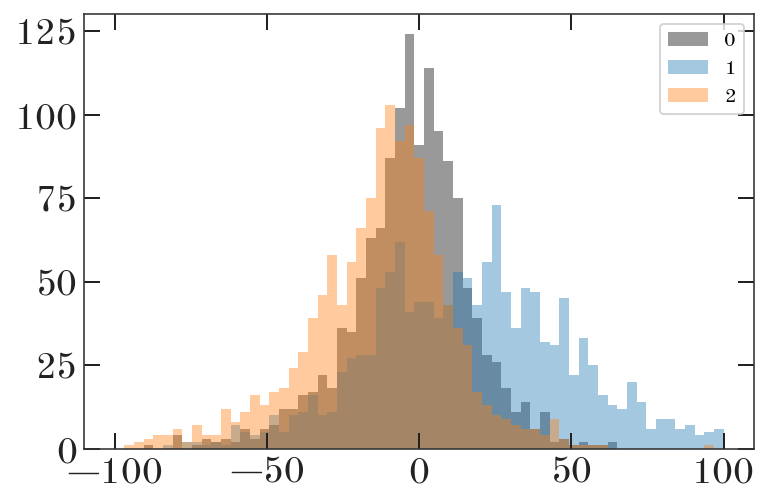

In [10]:
for i in range(3):
    _x = g[sep3d_mask].get_skycoord().velocity.d_xyz.value[i]
    print(1.5 * np.median(np.abs(_x - np.median(_x))),
          np.median(_x))
    plt.hist(g[sep3d_mask].get_skycoord().velocity.d_xyz.value[i],
             bins=np.linspace(-100, 100, 64), alpha=0.4, label=str(i));
plt.legend(loc='best')

In [11]:
test_vxyz = subg.get_skycoord().velocity.d_xyz.value.T
test_d = subg.distance.value

In [12]:
# vdisk = np.zeros(3)
vdisk = np.array([-2, 17.9, -10.6])
# sigma_disk = np.full(3, 30.)  # km/s
sigma_disk = np.array([15, 35, 20.])

vhalo = np.zeros(3)
sigma_halo = np.full(3, 125.)  # km/s

# Number of prior mixture components:
K = 3

with pm.Model() as model:
    r = pm.Uniform("r", 1, 500, shape=N, testval=test_d)
    
    # Mixture model for 3D velocity
    w = pm.Dirichlet('w', a=np.ones(K))
    
    _v0 = pm.Normal.dist(v0, np.full(3, sigma_0), 
                         shape=(N, 3))
    _v1 = pm.Normal.dist(vdisk, sigma_disk, 
                         shape=(N, 3))
    _v2 = pm.Normal.dist(vhalo, sigma_halo, 
                         shape=(N, 3))
    vxyz = pm.Mixture('vxyz', w=w, comp_dists=[_v0, _v1, _v2], 
                      testval=test_vxyz, shape=(N, 3)) 
    
    v0_logp = pm.Deterministic('v0_logp', _v0.logp(vxyz))
    v1_logp = pm.Deterministic('v1_logp', _v1.logp(vxyz))
    v2_logp = pm.Deterministic('v2_logp', _v2.logp(vxyz))
    
    # Velocity in tangent plane coordinates
    vtan = tt.batched_dot(M, vxyz)
    
    model_pm = vtan[:, :2] / r[:, None] * pc_mas_yr_per_km_s
    model_rv = vtan[:, 2:3]
    model_y = tt.concatenate((1000 / r[:, None], model_pm, model_rv), axis=1)
    
    for n in range(N):
        pm.MvNormal(f'y{n}', mu=model_y[n], cov=C[n], observed=y[n], shape=4)

In [13]:
with model:
    res = xo.optimize()

optimizing logp for variables: [vxyz, w, r]


message: Optimization terminated successfully.
logp: -3824.958965138262 -> -3192.5480918396493


In [14]:
logps = np.zeros((N, 3))
for n in range(3):
    logps[:, n] = res[f'v{n}_logp'].sum(axis=1)

In [15]:
from scipy.special import logsumexp

In [16]:
# for i in range(3):
#     _x = test_vxyz[:, i]
#     print(1.5 * np.median(np.abs(_x - np.median(_x))),
#           np.median(_x))
#     plt.hist(test_vxyz[:, i],
#              bins=np.linspace(-100, 100, 64), alpha=0.4, label=str(i),
#              density=True);
    
#     _grid = np.linspace(-100, 100, 1000)
#     plt.plot(_grid, norm.pdf(_grid, vdisk[i], sigma_disk[i]), marker='')
    
# plt.legend(loc='best')

In [17]:
prob = np.exp(logps[:, 0] - logsumexp(logps, axis=1))

(array([325.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,  16.]),
 array([0.        , 0.09999808, 0.19999615, 0.29999423, 0.3999923 ,
        0.49999038, 0.59998845, 0.69998653, 0.7999846 , 0.89998268,
        0.99998076]),
 <a list of 10 Patch objects>)

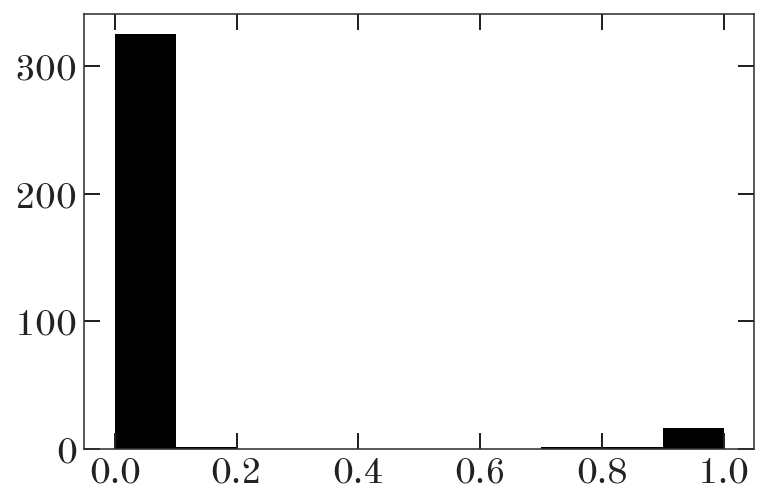

In [18]:
plt.hist(prob)

In [19]:
subg[prob > 0.5].source_id

1320894312595678976
1397457048152981632
1476485996883837184
1396617472242087168
1490845584382687232
1523644978312478976
1263985102569989504
1549259098113618688
1523645047031954944
4026742744369123584
1189404610382948224


In [26]:
highprob = subg[prob > 0.5]

mg = highprob.phot_g_mean_mag - highprob.distmod
bprp = highprob.phot_bp_mean_mag - highprob.phot_rp_mean_mag

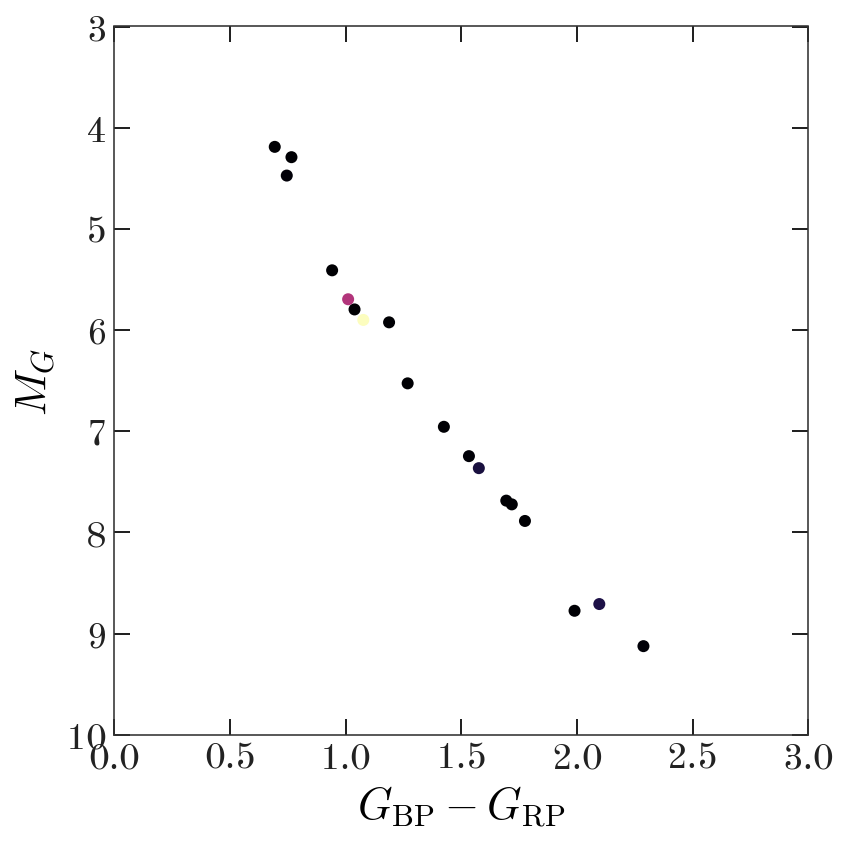

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(bprp, mg, c=prob[prob > 0.5], 
           cmap='magma_r')

ax.set_xlim(0, 3)
ax.set_ylim(10, 3)

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')
fig.tight_layout()

(-90.0, 90.0)

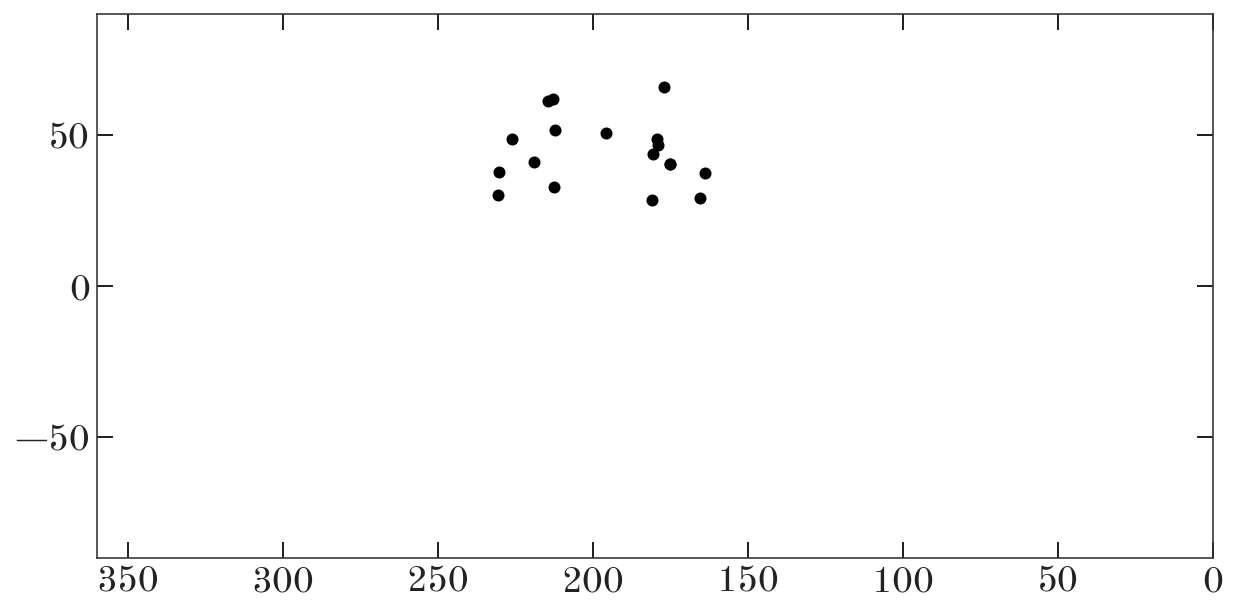

In [37]:
highprob_c = highprob.get_skycoord()

plt.figure(figsize=(10, 5))
plt.scatter(highprob_c.barycentricmeanecliptic.lon.degree,
            highprob_c.barycentricmeanecliptic.lat.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)

In [51]:
highprob_tbl = highprob.data
highprob_tbl['prob'] = prob[prob > 0.5]
highprob_tbl.write('/Users/apricewhelan/Downloads/TheOGGroup.csv', format='ascii.ecsv')